In [ ]:
pip install requests shapely geopandas

In [ ]:
pip install pyproj

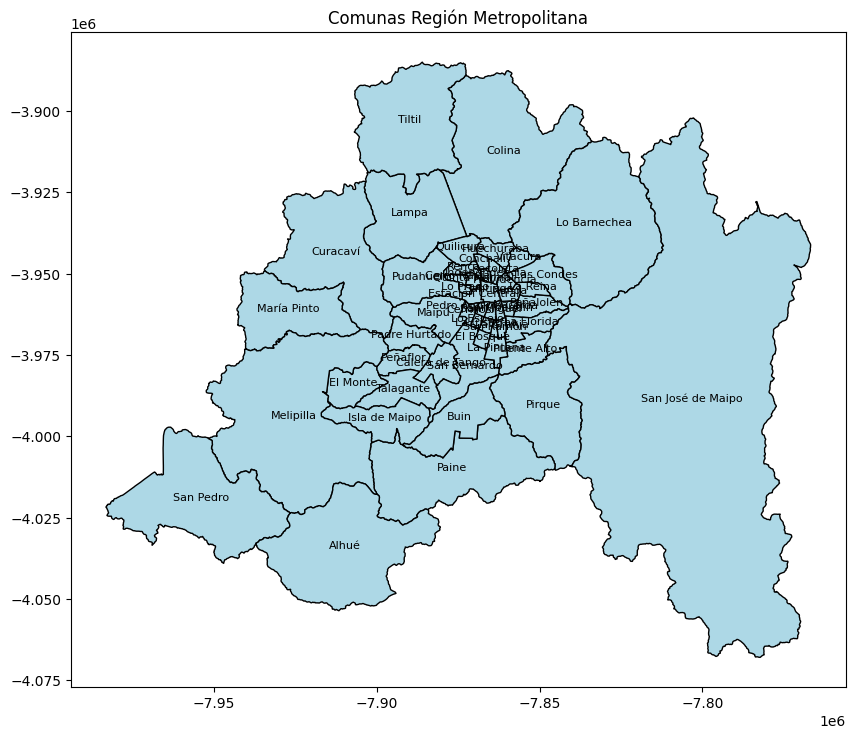

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

ruta_shp = "comunas.shp"
gdf = gpd.read_file(ruta_shp)

rm = gdf[gdf['Region'] == "Región Metropolitana de Santiago"]

ax = rm.plot(edgecolor='black', facecolor='lightblue', figsize=(10,10))
plt.title("Comunas Región Metropolitana")

for idx, row in rm.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    plt.text(x, y, row['Comuna'], fontsize=8, ha='center')

plt.show()


In [ ]:
print(rm.crs)

EPSG:3857


In [ ]:
rm = rm.to_crs(epsg=4326)
print(rm.crs)

EPSG:4326


In [ ]:
from shapely.geometry import Point

gdf = gpd.read_file("comunas.shp")
rm = gdf[gdf['Region'] == "Región Metropolitana de Santiago"]

rm = rm.to_crs(epsg=4326)

def comuna_de_punto(lat, lon, gdf_rm):
    punto = Point(lon, lat)
    comuna = gdf_rm[gdf_rm.contains(punto)]
    if not comuna.empty:
        return comuna.iloc[0]['Comuna']
    else:
        return None

lat, lon = -33.478024, -70.680204

nombre_comuna = comuna_de_punto(lat, lon, rm)
print(nombre_comuna or "No pertenece a ninguna comuna de la RM")

Santiago


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("merged_cleaned.csv", encoding="utf-8", delimiter=",")
df

precio  banos  dormitorios  superficie_total  \
0     322633576.0    3.0          5.0             404.0   
1     124089837.0    3.0          3.0             102.0   
2     157180460.0    2.0          3.0             190.0   
3     133544301.0    2.0          5.0             146.0   
4     117786861.0    2.0          3.0             145.0   
...           ...    ...          ...               ...   
5965  742425000.0    5.0          5.0             370.0   
5966   69709800.0    1.0          2.0              88.0   
5967   75000000.0    2.0          4.0             100.0   
5968  859650000.0    5.0          6.0            1000.0   
5969  349721250.0    4.0          5.0            1230.0   

      superficie_construida  estacionamiento    latitud   longitud  
0                     275.0              1.0 -33.345468 -70.678398  
1                      27.0              1.0 -33.563160 -70.776609  
2                     127.0              1.0 -33.563025 -70.559425  
3                      61.0              1.0 -33.641678 -70.689872  
4                      82.0              1.0 -33.613778 -70.887450  
...                     ...              ...        ...        ...  
5965                  230.0              0.0 -33.421135 -70.553193  
5966                   70.0              0.0 -33.513907 -70.783665  
5967                   80.0              0.0 -33.416357 -70.765798  
5968                  320.0              0.0 -34.147102 -71.462988  
5969                  192.0              1.0 -33.599666 -70.869676  

[5970 rows x 8 columns]

In [ ]:
df_mapa = pd.read_csv("propiedades_con_comuna.csv", encoding="utf-8", delimiter=",")
df_mapa.head()

precio  banos  dormitorios  superficie_total  superficie_construida  \
0  322633576.0    3.0          5.0             404.0                  275.0   
1  124089837.0    3.0          3.0             102.0                   27.0   
2  157180460.0    2.0          3.0             190.0                  127.0   
3  133544301.0    2.0          5.0             146.0                   61.0   
4  117786861.0    2.0          3.0             145.0                   82.0   

   estacionamiento    latitud   longitud        comuna  
0              1.0 -33.345468 -70.678398    Huechuraba  
1              1.0 -33.563160 -70.776609         Maipú  
2              1.0 -33.563025 -70.559425   Puente Alto  
3              1.0 -33.641678 -70.689872  San Bernardo  
4              1.0 -33.613778 -70.887450      Peñaflor

In [ ]:
import folium
import matplotlib.cm as cm
from folium import plugins

df_mapa = pd.read_csv("propiedades_con_comuna.csv", encoding="utf-8", delimiter=",")

df_mapa = df_mapa[df_mapa['comuna'].notna()].copy()
df_mapa['comuna'] = df_mapa['comuna'].astype(str).str.strip()

df_mapa.columns = df_mapa.columns.str.strip()

centro_lat = df_mapa['latitud'].mean()
centro_lon = df_mapa['longitud'].mean()

mapa = folium.Map(location=[centro_lat, centro_lon], zoom_start=9)

comunas_unicas = sorted(df_mapa['comuna'].unique())
n_comunas = len(comunas_unicas)

cmap = cm.get_cmap('tab20' if n_comunas <= 20 else 'hsv')
color_map = {
    comuna: '#{:02x}{:02x}{:02x}'.format(
        int(cmap(i / max(n_comunas-1, 1))[0]*255),
        int(cmap(i / max(n_comunas-1, 1))[1]*255),
        int(cmap(i / max(n_comunas-1, 1))[2]*255)
    )
    for i, comuna in enumerate(comunas_unicas)
}

puntos_agregados = 0
max_puntos = 2000
df_muestra = df_mapa.sample(n=min(len(df_mapa), max_puntos), random_state=42)

for _, row in df_muestra.iterrows():
    if pd.notnull(row['latitud']) and pd.notnull(row['longitud']):
        popup_text = f"""
        <b>Comuna:</b> {row['comuna']}<br>
        <b>Precio:</b> ${row['precio']:,.0f}<br>
        <b>Dormitorios:</b> {row['dormitorios']}<br>
        <b>Baños:</b> {row['banos']}<br>
        <b>Sup. Total:</b> {row['superficie_total']} m²<br>
        <b>Sup. Construida:</b> {row['superficie_construida']} m²<br>
        <b>Estacionamiento:</b> {row['estacionamiento']}
        """
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=4,
            popup=folium.Popup(popup_text, max_width=250),
            color='white',
            weight=1,
            fillColor=color_map[row['comuna']],
            fillOpacity=0.8,
            tooltip=f"{row['comuna']} - ${row['precio']:,.0f}"
        ).add_to(mapa)
        puntos_agregados += 1

top_comunas = df_mapa['comuna'].value_counts().head(10)
leyenda_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: 300px;
            background-color: white; border:2px solid grey; z-index:9999;
            font-size:12px; padding: 8px; overflow-y: auto;">
<p><b>Top 10 Comunas</b></p>
'''

for comuna in top_comunas.index:
    leyenda_html += f'<p><span style="color:{color_map[comuna]}; font-size:16px;">●</span> {comuna} ({top_comunas[comuna]})</p>'

leyenda_html += f'<p><i>... y {n_comunas - 10} comunas más</i></p></div>'

mapa.get_root().html.add_child(folium.Element(leyenda_html))

plugins.Fullscreen().add_to(mapa)
mapa.save("mapa_propiedades_por_comuna.html")
print(f"Mapa guardado con {puntos_agregados} puntos en {n_comunas} comunas.")
mapa


/tmp/ipython-input-1127962220.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20' if n_comunas <= 20 else 'hsv')


Mapa guardado con 2000 puntos en 51 comunas.


In [ ]:
url = "https://www.bcn.cl/siit/mapoteca/comunas"

In [ ]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "es-CL,es;q=0.9,en;q=0.8",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Cache-Control": "max-age=0"
}

In [ ]:
import requests
import csv
from bs4 import BeautifulSoup
import time
import re

In [ ]:
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.text, 'html.parser')

region_header = soup.find('a', string="Región Metropolitana de Santiago")

accordion_group = region_header.find_parent('div', class_='accordion-group')

comuna_links = accordion_group.find_all('a', class_='list-group-item')

comunas_urls = []

for link in comuna_links:
    nombre = link.text.strip()
    onclick = link.get('onclick', '')

    match = re.search(r"envia3\('comuna_view',\s*'.*?',\s*'(\d+)'\)", onclick)
    if match:
        codigo = match.group(1)
        url = f"https://www.bcn.cl/siit/reportescomunales/comunas_v.html?anno=2025&idcom={codigo}"
        comunas_urls.append((nombre, url))

with open('comunas_rm.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['comuna', 'url'])
    writer.writerows(comunas_urls)

print("✅ Archivo CSV guardado como comunas_rm.csv")

In [ ]:
df = pd.DataFrame(comunas_urls, columns=['comuna', 'url'])
print(df['url'])

In [ ]:
for idx, row in df.iterrows():
    comuna = row['comuna']
    url = row['url']

    print(f"\n📍 Procesando {comuna}...")
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    bloques = soup.find_all("div", class_="z-depth-1 p-4 rounded mb-5")

    print(f"🔍 Se encontraron {len(bloques)} bloques con esa clase.")

    for i, bloque in enumerate(bloques, start=1):
        h6 = bloque.find("h6")
        if h6:
            h6_text = h6.get_text(strip=True)
            print(f"\nTabla: {h6_text}")
        else:
            print(f"\nTabla #{i}: Sin título (no tiene h6)")

        tabla = bloque.find("table")
        if tabla:
            filas = tabla.find_all("tr")
            for fila in filas:
                celdas = fila.find_all(['td', 'th'])  # Incluye encabezados si existen
                texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                print(" | ".join(texto_celdas))
        else:
            print("No se encontró tabla en este bloque.")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
País | 13,1 | 8,1

Tabla: 3.1 Número de establecimientos de salud, según tipo información al 29-04-2025

Tipo Establecimiento | Comuna (n°) | Región (n°) | País (n°)
Atención Remota | 0 | 2 | 2
Centro Comunitario de Salud Familiar (CECOSF) | 3 | 70 | 293
Centro Comunitario de Salud Mental  (COSAM) | 1 | 44 | 102
Centro Corporación para la Nutrición Infantil (CONIN) | 0 | 1 | 5
Centro de Apoyo Comunitario para Personas con Demencia | 0 | 1 | 6
Centro Diagnóstico Terapéutico y Tratamiento Privado (CDT) | 0 | 0 | 43
Centro de Diálisis | 0 | 2 | 97
Centro de Especialidad | 0 | 3 | 8
Centro de Referencia de Salud (CRS) | 0 | 6 | 11
Centro de Regulación Médica de las Urgencias (SAMU) | 0 | 1 | 1
Centro de Rehabilitación | 0 | 1 | 7
Centro de Salud de Atención Cerrada para Personas Privadas de Libertad | 0 | 0 | 1
Centro de Salud Familiar (CESFAM) | 4 | 172 | 602
Centro de Salud Mental | 0 | 0 | 1
Centro de Salud Privado | 6 |

In [ ]:
def limpiar_valor(valor):
    if valor is None or valor == "":
        return valor
    valor_str = str(valor)
    if ',' in valor_str:
        valor_str = valor_str.replace('.', '')
        valor_str = valor_str.replace(',', '.')
    else:
        partes_punto = valor_str.split('.')
        if len(partes_punto) > 2 or (len(partes_punto) == 2 and len(partes_punto[-1]) > 2):
            valor_str = valor_str.replace('.', '')
    valor_str = valor_str.replace('%', '')
    valor_str = valor_str.strip()
    return valor_str

def extraer_dato_comuna(filas, posicion_comuna=0):
    for fila in filas[1:]:
        celdas = fila.find_all(['td', 'th'])
        if len(celdas) > posicion_comuna:
            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
            if "Comuna de" in texto_celdas[0]:
                return texto_celdas
    return None

datos_todas_comunas = []

for idx, row in df.iterrows():
    comuna = row['comuna']
    url = row['url']

    print(f"\n📍 Procesando {comuna}...")

    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    bloques = soup.find_all("div", class_="z-depth-1 p-4 rounded mb-5")

    print(f"🔍 Se encontraron {len(bloques)} bloques con esa clase.")

    datos_comuna = {'Comuna': comuna}

    for i, bloque in enumerate(bloques, start=1):
        h6 = bloque.find("h6")
        if h6:
            h6_text = h6.get_text(strip=True)

            tabla = bloque.find("table")
            if tabla:
                filas = tabla.find_all("tr")

                if "1.1" in h6_text and "Población total" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Población 2024'] = limpiar_valor(datos_fila[2])

                elif "1.2" in h6_text and ("Urbana-Rural" in h6_text or "ÁreaUrbana-Rural" in h6_text):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 6:
                        datos_comuna['Ruralidad 2024 (%)'] = limpiar_valor(datos_fila[6])

                elif "1.3" in h6_text and "sexo" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 6:
                        datos_comuna['Índice Masculinidad 2024'] = limpiar_valor(datos_fila[6])

                elif "1.4" in h6_text and "grupos de edad" in h6_text:
                    for fila in filas[1:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 4:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            if texto_celdas[0] and texto_celdas[0] != "Total":
                                if "Censo 2017" not in texto_celdas[0]:
                                    grupo_nombre = texto_celdas[0].replace(" ", "_")
                                    datos_comuna[f'Grupo_Etario_{grupo_nombre}_2024_(%)'] = limpiar_valor(texto_celdas[3])

                elif "1.5" in h6_text and ("Dependencia" in h6_text or "Adultos Mayores" in h6_text):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 4:
                        datos_comuna['IDD 2024'] = limpiar_valor(datos_fila[2])
                        datos_comuna['IAM 2024'] = limpiar_valor(datos_fila[4])

                elif "2.1" in h6_text and "Pobreza por ingresos" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Pobreza por ingresos 2022 (%)'] = limpiar_valor(datos_fila[2])

                elif "2.2" in h6_text and "multidimensional" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Pobreza multidimensional 2022 (%)'] = limpiar_valor(datos_fila[2])

                elif "2.3" in h6_text and ("indígenas" in h6_text or "Extranjeros" in h6_text):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Pueblos indígenas 2025 (%)'] = limpiar_valor(datos_fila[1])
                        datos_comuna['Extranjeros 2025 (%)'] = limpiar_valor(datos_fila[2])

                elif "2.4" in h6_text and ("servicios básicos" in h6_text or "hacinados" in h6_text):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Carentes servicios básicos 2025 (%)'] = limpiar_valor(datos_fila[1])
                        datos_comuna['Hogares hacinados 2025 (%)'] = limpiar_valor(datos_fila[2])

                elif "3.1" in h6_text and "salud" in h6_text:
                    for fila in filas[2:-1]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 2:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            tipo_establecimiento = texto_celdas[0]
                            comuna_valor = limpiar_valor(texto_celdas[1])
                            datos_comuna[f"Cantidad de: {tipo_establecimiento} 2025"] = comuna_valor

                elif "3.2" in h6_text and "Población inscrita" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) >= 3:
                        datos_comuna['Población inscrita comuna 2023'] = datos_fila[0]

                elif "3.3" in h6_text and ("fecundidad" in h6_text.lower() or "natalidad" in h6_text.lower()):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Fecundidad 2022'] = limpiar_valor(datos_fila[1])
                        datos_comuna['Natalidad 2022'] = limpiar_valor(datos_fila[2])

                elif "3.4" in h6_text and ("mortalidad general" in h6_text.lower() or "mortalidad infantil" in h6_text.lower()):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['Mortalidad General 2022 (c/1.000 hab)'] = limpiar_valor(datos_fila[1])
                        datos_comuna['Mortalidad Infantil 2022 (c/1.000 nac.vivos)'] = limpiar_valor(datos_fila[2])

                elif "4.2" in h6_text and "Matrícula escolar" in h6_text:
                    for fila in filas[1:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 3:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            tipo_matricula = texto_celdas[0]
                            if "Matricula Municipal" in tipo_matricula:
                                datos_comuna['Matrícula Municipal 2024'] = limpiar_valor(texto_celdas[2])
                            elif "Matricula Subvencionada" in tipo_matricula:
                                datos_comuna['Matrícula Subvencionada 2024'] = limpiar_valor(texto_celdas[2])
                            elif "Matricula Particular Pagado" in tipo_matricula:
                                datos_comuna['Matrícula Particular Pagado 2024'] = limpiar_valor(texto_celdas[2])
                            elif "Matricula Corporación de Administración Delegada" in tipo_matricula:
                                datos_comuna['Matrícula Corporación Admin Delegada 2024'] = limpiar_valor(texto_celdas[2])
                            elif "Matricula Servicio Local de Educación" in tipo_matricula:
                                datos_comuna['Matrícula Servicio Local Educación 2024'] = limpiar_valor(texto_celdas[2])

                elif "4.3" in h6_text and "nivel de enseñanza" in h6_text:
                    for fila in filas[2:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 3:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            nivel_enseñanza = texto_celdas[0]
                            if nivel_enseñanza and nivel_enseñanza != "Total":
                                if len(texto_celdas) > 2:
                                    valor_comuna_2024 = limpiar_valor(texto_celdas[2])
                                    if valor_comuna_2024 == "-":
                                        valor_comuna_2024 = "0"
                                    nivel_limpio = nivel_enseñanza.replace(",", "").replace(" ", "_")
                                    clave_columna = f"Matrícula_{nivel_limpio}_2024"
                                    datos_comuna[clave_columna] = valor_comuna_2024

                elif "4.4" in h6_text and "4to básico" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['SIMCE 4to Básico Lectura 2022'] = limpiar_valor(datos_fila[1])
                        datos_comuna['SIMCE 4to Básico Matemáticas 2022'] = limpiar_valor(datos_fila[2])

                elif "4.5" in h6_text and "2do Medio" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 2:
                        datos_comuna['SIMCE 2do Medio Lectura 2022'] = limpiar_valor(datos_fila[1])
                        datos_comuna['SIMCE 2do Medio Matemáticas 2022'] = limpiar_valor(datos_fila[2])

                elif "5.1" in h6_text and ("empresas" in h6_text.lower() or "tamaño" in h6_text.lower()):
                    for fila in filas[2:-1]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 4:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            tramo_empresa = texto_celdas[0]
                            if tramo_empresa:
                                if len(texto_celdas) > 3:
                                    valor_comuna_2023 = limpiar_valor(texto_celdas[3])
                                    if tramo_empresa == "Sin Ventas/Sin Información":
                                        clave_columna = "Empresas_Sin_Ventas_Sin_Información_2023"
                                    else:
                                        tramo_limpio = tramo_empresa.replace(" ", "_")
                                        clave_columna = f"Empresas_{tramo_limpio}_2023"
                                    datos_comuna[clave_columna] = valor_comuna_2023

                elif "5.2" in h6_text and ("trabajadores" in h6_text.lower() or "dependientes" in h6_text.lower()):
                    for fila in filas[2:-1]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 4:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            tramo_empresa = texto_celdas[0]
                            if tramo_empresa:
                                if len(texto_celdas) > 3:
                                    valor_comuna_2023 = limpiar_valor(texto_celdas[3])
                                    if tramo_empresa == "Sin Ventas/Sin Información":
                                        clave_columna = "Trabajadores_Sin_Ventas_Sin_Información_2023"
                                    else:
                                        tramo_limpio = tramo_empresa.replace(" ", "_")
                                        clave_columna = f"Trabajadores_{tramo_limpio}_2023"
                                    datos_comuna[clave_columna] = valor_comuna_2023

                elif "5.3" in h6_text and ("rubro" in h6_text.lower() or "económico" in h6_text.lower()):
                    for fila in filas[2:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 4:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            rubro_economico = texto_celdas[0]
                            if rubro_economico:
                                if len(texto_celdas) > 3:
                                    valor_comuna_2023 = limpiar_valor(texto_celdas[3])
                                    if "Agricultura ganadería silvicultura y pesca" in rubro_economico:
                                        clave_columna = "Empresas_Agricultura_Ganadería_2023"
                                    elif "Explotación de minas y canteras" in rubro_economico:
                                        clave_columna = "Empresas_Minería_2023"
                                    elif "Industria manufacturera" in rubro_economico:
                                        clave_columna = "Empresas_Industria_Manufacturera_2023"
                                    elif "Suministro de electricidad gas vapor" in rubro_economico:
                                        clave_columna = "Empresas_Suministro_Electricidad_2023"
                                    elif "Suministro de agua evacuación" in rubro_economico:
                                        clave_columna = "Empresas_Suministro_Agua_2023"
                                    elif "Construcción" == rubro_economico:
                                        clave_columna = "Empresas_Construcción_2023"
                                    elif "Comercio al por mayor y al por menor" in rubro_economico:
                                        clave_columna = "Empresas_Comercio_2023"
                                    elif "Transporte y almacenamiento" in rubro_economico:
                                        clave_columna = "Empresas_Transporte_2023"
                                    elif "Actividades de alojamiento y de servicio de comidas" in rubro_economico:
                                        clave_columna = "Empresas_Alojamiento_Comidas_2023"
                                    elif "Información y comunicaciones" in rubro_economico:
                                        clave_columna = "Empresas_Información_Comunicaciones_2023"
                                    elif "Actividades financieras y de seguros" in rubro_economico:
                                        clave_columna = "Empresas_Financieras_Seguros_2023"
                                    elif "Actividades inmobiliarias" in rubro_economico:
                                        clave_columna = "Empresas_Inmobiliarias_2023"
                                    elif "Actividades profesionales científicas y técnicas" in rubro_economico:
                                        clave_columna = "Empresas_Profesionales_Científicas_2023"
                                    elif "Actividades de servicios administrativos" in rubro_economico:
                                        clave_columna = "Empresas_Servicios_Administrativos_2023"
                                    elif "Administración pública y defensa" in rubro_economico:
                                        clave_columna = "Empresas_Administración_Pública_2023"
                                    elif "Enseñanza" == rubro_economico:
                                        clave_columna = "Empresas_Enseñanza_2023"
                                    elif "Actividades de atención de la salud" in rubro_economico:
                                        clave_columna = "Empresas_Salud_2023"
                                    elif "Actividades artísticas de entretenimiento" in rubro_economico:
                                        clave_columna = "Empresas_Artísticas_Entretenimiento_2023"
                                    elif "Otras actividades de servicios" in rubro_economico:
                                        clave_columna = "Empresas_Otras_Actividades_2023"
                                    elif "Actividades de los hogares como empleadores" in rubro_economico:
                                        clave_columna = "Empresas_Hogares_Empleadores_2023"
                                    elif "Actividades de organizaciones y órganos extraterritoriales" in rubro_economico:
                                        clave_columna = "Empresas_Organizaciones_Extraterritoriales_2023"
                                    elif "Sin información" in rubro_economico:
                                        clave_columna = "Empresas_Sin_Información_2023"
                                    else:
                                        rubro_limpio = rubro_economico.replace(" ", "_").replace(",", "")[:50]
                                        clave_columna = f"Empresas_{rubro_limpio}_2023"
                                    datos_comuna[clave_columna] = valor_comuna_2023

                elif "5.4" in h6_text and ("trabajadores" in h6_text.lower() and "rubro" in h6_text.lower()):
                    for fila in filas[2:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 4:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            rubro_economico = texto_celdas[0]
                            if rubro_economico:
                                if len(texto_celdas) > 3 utiliza:
                                    valor_comuna_2023 = limpiar_valor(texto_celdas[3])
                                    if "Agricultura ganadería silvicultura y pesca" in rubro_economico:
                                        clave_columna = "Trabajadores_Agricultura_Ganadería_2023"
                                    elif "Explotación de minas y canteras" in rubro_economico:
                                        clave_columna = "Trabajadores_Minería_2023"
                                    elif "Industria manufacturera" in rubro_economico:
                                        clave_columna = "Trabajadores_Industria_Manufacturera_2023"
                                    elif "Suministro de electricidad gas vapor" in rubro_economico:
                                        clave_columna = "Trabajadores_Suministro_Electricidad_2023"
                                    elif "Suministro de agua evacuación" in rubro_economico:
                                        clave_columna = "Trabajadores_Suministro_Agua_2023"
                                    elif "Construcción" == rubro_economico:
                                        clave_columna = "Trabajadores_Construcción_2023"
                                    elif "Comercio al por mayor y al por menor" in rubro_economico:
                                        clave_columna = "Trabajadores_Comercio_2023"
                                    elif "Transporte y almacenamiento" in rubro_economico:
                                        clave_columna = "Trabajadores_Transporte_2023"
                                    elif "Actividades de alojamiento y de servicio de comidas" in rubro_economico:
                                        clave_columna = "Trabajadores_Alojamiento_Comidas_2023"
                                    elif "Información y comunicaciones" in rubro_economico:
                                        clave_columna = "Trabajadores_Información_Comunicaciones_2023"
                                    elif "Actividades financieras y de seguros" in rubro_economico:
                                        clave_columna = "Trabajadores_Financieras_Seguros_2023"
                                    elif "Actividades inmobiliarias" in rubro_economico:
                                        clave_columna = "Trabajadores_Inmobiliarias_2023"
                                    elif "Actividades profesionales científicas y técnicas" in rubro_economico:
                                        clave_columna = "Trabajadores_Profesionales_Científicas_2023"
                                    elif "Actividades de servicios administrativos" in rubro_economico:
                                        clave_columna = "Trabajadores_Servicios_Administrativos_2023"
                                    elif "Administración pública y defensa" in rubro_economico:
                                        clave_columna = "Trabajadores_Administración_Pública_2023"
                                    elif "Enseñanza" == rubro_economico:
                                        clave_columna = "Trabajadores_Enseñanza_2023"
                                    elif "Actividades de atención de la salud" in rubro_economico:
                                        clave_columna = "Trabajadores_Salud_2023"
                                    elif "Actividades artísticas de entretenimiento" in rubro_economico:
                                        clave_columna = "Trabajadores_Artísticas_Entretenimiento_2023"
                                    elif "Otras actividades de servicios" in rubro_economico:
                                        clave_columna = "Trabajadores_Otras_Actividades_2023"
                                    elif "Actividades de los hogares como empleadores" in rubro_economico:
                                        clave_columna = "Trabajadores_Hogares_Empleadores_2023"
                                    elif "Actividades de organizaciones y órganos extraterritoriales" in rubro_economico:
                                        clave_columna = "Trabajadores_Organizaciones_Extraterritoriales_2023"
                                    elif "Sin información" in rubro_economico:
                                        clave_columna = "Trabajadores_Sin_Información_2023"
                                    else:
                                        rubro_limpio = rubro_economico.replace(" ", "_").replace(",", "")[:50]
                                        clave_columna = f"Trabajadores_{rubro_limpio}_2023"
                                    datos_comuna[clave_columna] = valor_comuna_2023

                elif "6.1" in h6_text and ("Ingresos Propios" in h6_text or "ingreso" in h6_text.lower()):
                    for fila in filas[1:]:
                        celdas = fila.find_all(['td', 'th'])
                        if len(celdas) >= 3:
                            texto_celdas = [celda.get_text(strip=True).replace("\xa0", " ") for celda in celdas]
                            tipo_ingreso = texto_celdas[0]
                            if "Disponibilidad Presupuestaria Municipal por Habitante" in tipo_ingreso:
                                if len(texto_celdas) > 2:
                                    valor_2023 = limpiar_valor(texto_celdas[2])
                                    datos_comuna['Disponibilidad_Presupuestaria_por_Habitante_2023_(M$)'] = valor_2023
                                break

                elif "7.1" in h6_text and ("Delitos de Mayor Connotación Social" in h6_text or "Denuncias" in h6_text):
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 3:
                        datos_comuna['Delitos Mayor Connotación Social 2023 (c/100.000 hab)'] = limpiar_valor(datos_fila[3])

                elif "7.2" in h6_text and "Violencia Intrafamiliar" in h6_text:
                    datos_fila = extraer_dato_comuna(filas)
                    if datos_fila and len(datos_fila) > 3:
                        datos_comuna['Violencia Intrafamiliar 2023 (c/100.000 hab)'] = limpiar_valor(datos_fila[3])

    datos_todas_comunas.append(datos_comuna)

    print(f"✅ Datos extraídos para {comuna}")

print("\n📝 Creando archivo CSV...")
df_resultados = pd.DataFrame(datos_todas_comunas)

nombre_archivo = "datos_comunas_extraidos.csv"
df_resultados.to_csv(nombre_archivo, index=False, encoding='utf-8-sig')

print(f"✅ Archivo '{nombre_archivo}' creado exitosamente!")
print(f"📊 Total de comunas procesadas: {len(datos_todas_comunas)}")
print(f"📋 Total de columnas en el CSV: {len(df_resultados.columns)}")

print("\n👀 Vista previa del archivo CSV:")
print(df_resultados.head())


📍 Procesando Alhué...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Alhué

📍 Procesando Buin...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Buin

📍 Procesando Calera de Tango...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Calera de Tango

📍 Procesando Cerrillos...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Cerrillos

📍 Procesando Cerro Navia...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Cerro Navia

📍 Procesando Colina...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Colina

📍 Procesando Conchalí...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Conchalí

📍 Procesando Curacaví...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para Curacaví

📍 Procesando El Bosque...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraídos para El Bosque

📍 Procesando El Monte...
🔍 Se encontraron 33 bloques con esa clase.
✅ Datos extraído